# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

# Model description

**Write out the model in equations here.** 

Make sure you explain well the purpose of the model and comment so that other students who may not have seen it before can follow.  

## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

In [5]:
import sympy as sp

# Define symbols
s_K, s_H, alpha, phi, n, g, delta = sp.symbols('s_K s_H alpha phi n g delta')

# Steady state equations
k_star = ((s_K**(1-phi) * s_H**phi) / (n + g + delta + n*g))**(1/(1-alpha-phi))
h_star = ((s_K**alpha * s_H**(1-alpha)) / (n + g + delta + n*g))**(1/(1-alpha-phi))
y_star = (s_K / (n + g + delta + n*g))**(alpha/(1-alpha-phi)) * \
         (s_H / (n + g + delta + n*g))**(phi/(1-alpha-phi))

# Lambdify the steady state functions
steady_state_k = sp.lambdify((s_K, s_H, alpha, phi, n, g, delta), k_star)
steady_state_h = sp.lambdify((s_K, s_H, alpha, phi, n, g, delta), h_star)
steady_state_y = sp.lambdify((s_K, s_H, alpha, phi, n, g, delta), y_star)

# Example usage:
# Suppose we want to evaluate steady-state values for specific parameter values
s_K_val = 0.3  # Savings rate for physical capital
s_H_val = 0.2  # Savings rate for human capital
alpha_val = 0.3
phi_val = 0.2
n_val = 0.02  # Labor force growth rate
g_val = 0.01  # Technology growth rate
delta_val = 0.1  # Depreciation rate

# Calculate steady-state values
k_star_val = steady_state_k(s_K_val, s_H_val, alpha_val, phi_val, n_val, g_val, delta_val)
h_star_val = steady_state_h(s_K_val, s_H_val, alpha_val, phi_val, n_val, g_val, delta_val)
y_star_val = steady_state_y(s_K_val, s_H_val, alpha_val, phi_val, n_val, g_val, delta_val)

# Print steady-state values
print("Steady-state capital (k*):", k_star_val)
print("Steady-state human capital (h*):", h_star_val)
print("Steady-state output per effective worker (y*):", y_star_val)






Steady-state capital (k*): 4.514233687364319
Steady-state human capital (h*): 3.0094891249095475
Steady-state output per effective worker (y*): 1.9591774203161147


Steady state for the RCK model

In [2]:
import sympy as sp

# Define symbols
K, c, alpha, rho, theta, delta, n, L, u = sp.symbols('K c alpha rho theta delta n L u')
lam = sp.symbols('lambda')  # Shadow price of capital

# Production function
Y = K**alpha * L**(1 - alpha)

# Utility function (assuming constant relative risk aversion)
U = (c**(1 - theta) - 1) / (1 - theta)

# Hamiltonian
H = U + lam * (Y - c * L - delta * K)

# Capital accumulation equation
cap_accum = sp.Eq(K.diff(), Y - c - delta * K)

# First order conditions
foc_K = sp.diff(H, K)
foc_c = sp.diff(H, c)
foc_lambda = sp.diff(H, lam)

# Solve for steady state where time derivatives are zero
steady_state = sp.solve((foc_c, foc_K, foc_lambda, cap_accum), (K, c, lam), dict=True)

# Display the steady state solutions
print("Steady State Solutions:")
for sol in steady_state:
    print(f"Capital (K*): {sol[K]}, Consumption (c*): {sol[c]}, Lambda (λ*): {sol[lam]}")



Steady State Solutions:
Capital (K*): (L**(1 - alpha)*alpha/delta)**(-1/(alpha - 1)), Consumption (c*): L**(1 - alpha)*((L**(1 - alpha)*alpha/delta)**(-1/(alpha - 1)))**alpha - delta/(L**(1 - alpha)*alpha/delta)**(1/(alpha - 1)) - 1, Lambda (λ*): 1/(L*(L**(1 - alpha)*((L**(1 - alpha)*alpha/delta)**(-1/(alpha - 1)))**alpha - delta/(L**(1 - alpha)*alpha/delta)**(1/(alpha - 1)) - 1)**theta)


## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

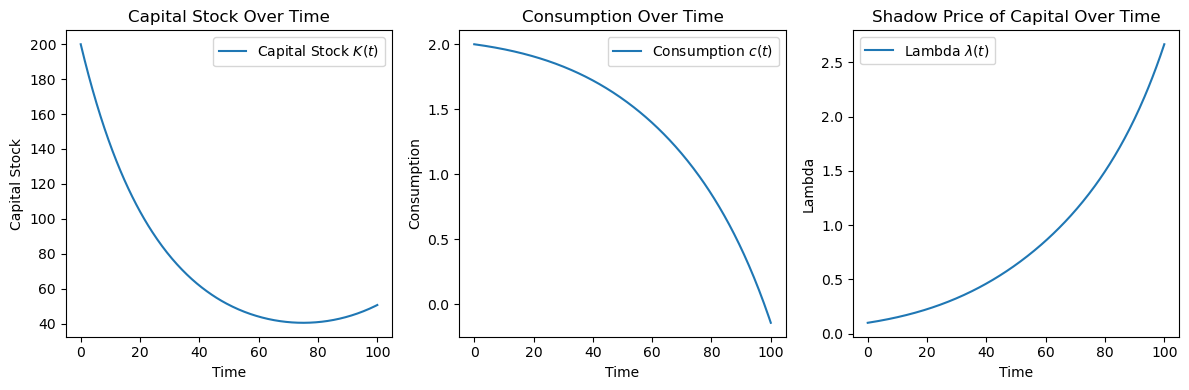

In [52]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
alpha = 0.3   # Output elasticity of capital
delta = 0.05  # Depreciation rate of capital
rho = 0.02    # Rate of time preference
theta = 2.0   # Coefficient of relative risk aversion
n = 0.01      # Labor growth rate

# Production function
def production(K, L):
    return K**alpha * L**(1 - alpha)

# Utility function
def utility(c):
    return (c**(1 - theta) - 1) / (1 - theta)

# Differential equations from Hamiltonian
def rck_system(t, z):
    K, c, lam = z
    Y = production(K, 1)  # Assume constant labor force for simplicity
    dot_K = Y - c - delta * K
    dot_c = (lam / theta) * (alpha * Y / K - rho - delta)
    dot_lam = -lam * ((alpha * Y / K) - delta)
    return [dot_K, dot_c, dot_lam]

# Initial conditions
initial_conditions = [200, 2, 0.1]  # Initial capital, consumption, lambda

# Time span for the simulation
t_span = (0, 100)
t_eval = np.linspace(*t_span, 300)

# Solve the differential equations
solution = solve_ivp(rck_system, t_span, initial_conditions, t_eval=t_eval, method='BDF')

# Plotting results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(solution.t, solution.y[0], label='Capital Stock $K(t)$')
plt.title('Capital Stock Over Time')
plt.xlabel('Time')
plt.ylabel('Capital Stock')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(solution.t, solution.y[1], label='Consumption $c(t)$')
plt.title('Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(solution.t, solution.y[2], label='Lambda $\lambda(t)$')
plt.title('Shadow Price of Capital Over Time')
plt.xlabel('Time')
plt.ylabel('Lambda')
plt.legend()

plt.tight_layout()
plt.show()


# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Changes of parameter values - sensitivity analysis

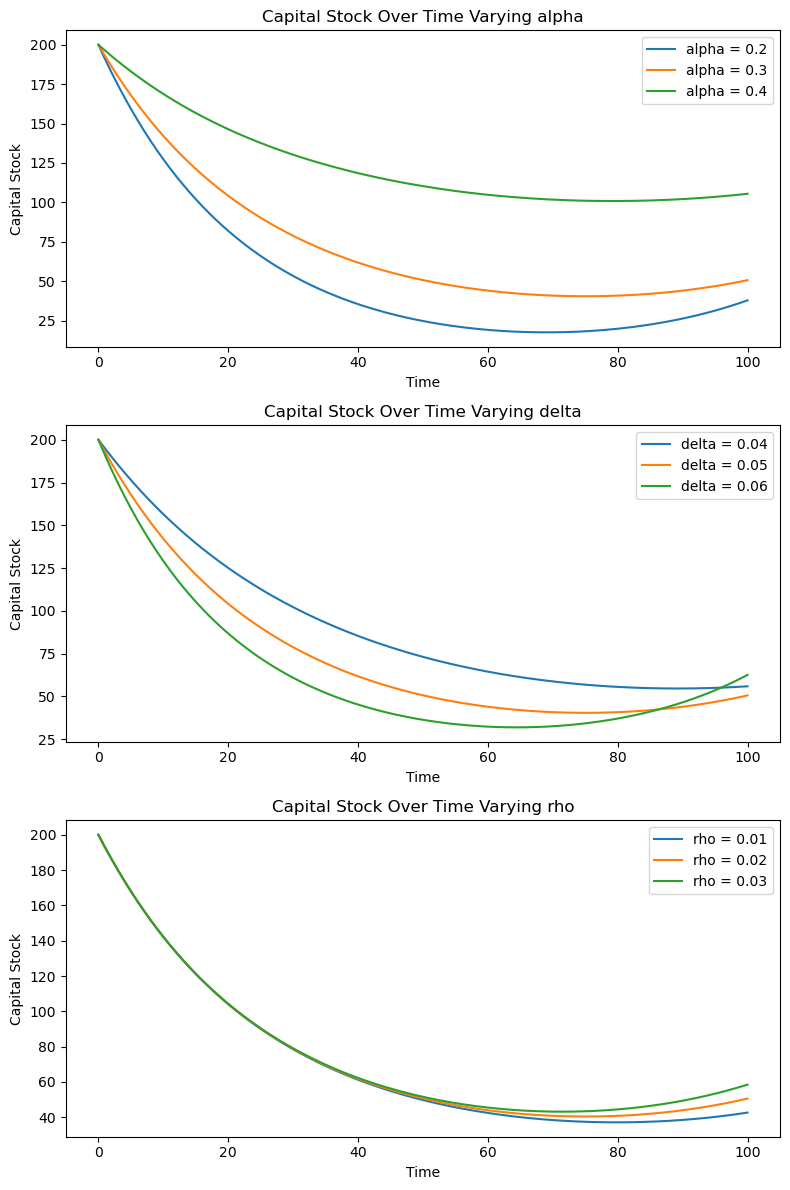

In [53]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
base_params = {
    'alpha': 0.3,
    'delta': 0.05,
    'rho': 0.02,
    'theta': 2.0,
    'n': 0.01
}

# Production function
def production(K, L, alpha):
    return K**alpha * L**(1 - alpha)

# Utility function
def utility(c, theta):
    return (c**(1 - theta) - 1) / (1 - theta)

# Differential equations from Hamiltonian
def rck_system(t, z, alpha, delta, rho, theta):
    K, c, lam = z
    Y = production(K, 1, alpha)  # Assume constant labor force for simplicity
    dot_K = Y - c - delta * K
    dot_c = (lam / theta) * (alpha * Y / K - rho - delta)
    dot_lam = -lam * ((alpha * Y / K) - delta)
    return [dot_K, dot_c, dot_lam]

# Initial conditions
initial_conditions = [200, 2, 0.1]  # Initial capital, consumption, lambda

# Time span for the simulation
t_span = (0, 100)
t_eval = np.linspace(*t_span, 300)

# Creating a plot
fig, ax = plt.subplots(3, 1, figsize=(8, 12))

# Parameter variations
for idx, (param, values) in enumerate({'alpha': [0.2, 0.3, 0.4], 'delta': [0.04, 0.05, 0.06], 'rho': [0.01, 0.02, 0.03]}.items()):
    for value in values:
        params = base_params.copy()
        params[param] = value
        solution = solve_ivp(rck_system, t_span, initial_conditions, args=(params['alpha'], params['delta'], params['rho'], params['theta']), t_eval=t_eval, method='BDF')
        ax[idx].plot(solution.t, solution.y[0], label=f'{param} = {value}')
    ax[idx].set_title(f'Capital Stock Over Time Varying {param}')
    ax[idx].set_xlabel('Time')
    ax[idx].set_ylabel('Capital Stock')
    ax[idx].legend()

plt.tight_layout()
plt.show()


# Extension with technological growth

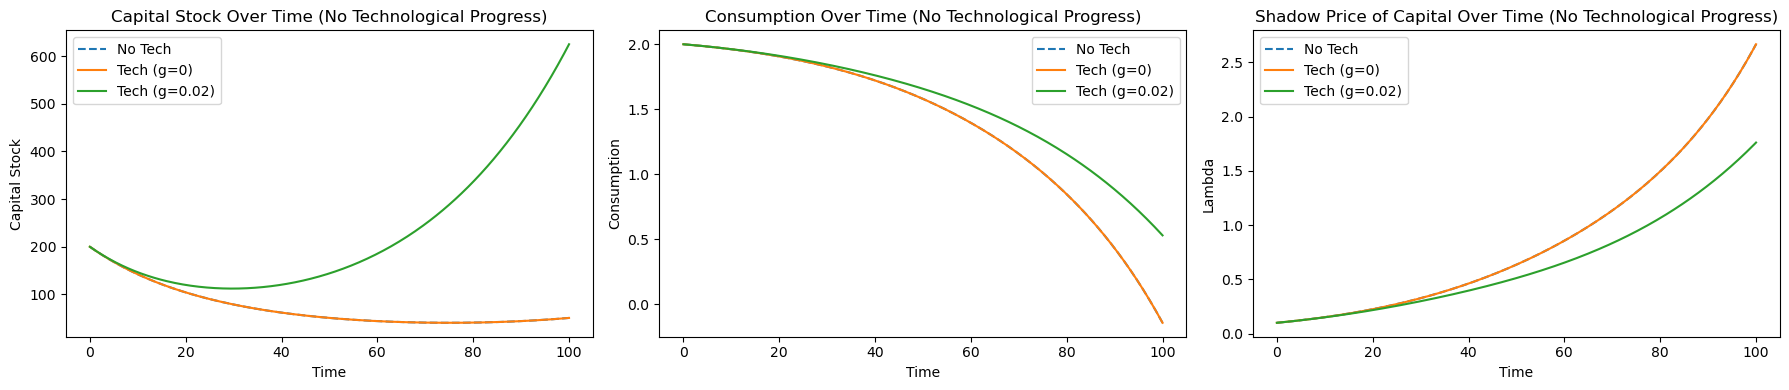

In [56]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
alpha = 0.3     # Output elasticity of capital
delta = 0.05    # Depreciation rate of capital
rho = 0.02      # Rate of time preference
theta = 2.0     # Coefficient of relative risk aversion
n = 0.01        # Labor growth rate
g_values = [0, 0.02]  # Technological growth rate for sensitivity analysis

# Production function
def production(K, L, A):
    return A * (K**alpha) * (L**(1-alpha))

# Utility function
def utility(c):
    return (c**(1 - theta) - 1) / (1 - theta)

# Differential equations from Hamiltonian with technological progress
def rck_system_with_tech(t, z, g):
    K, c, lam, A = z
    Y = production(K, 1, A)  # Assume constant labor force for simplicity
    dot_K = Y - c - delta * K
    dot_c = (lam / theta) * (alpha * Y / K - rho - delta)
    dot_lam = -lam * ((alpha * Y / K) - delta)
    dot_A = g * A
    return [dot_K, dot_c, dot_lam, dot_A]

# Solve RCK model without technological progress
def solve_rck_model(t_span, initial_conditions):
    return solve_ivp(rck_system_with_tech, t_span, initial_conditions, args=(0,), t_eval=t_eval, method='BDF')

# Solve RCK model with technological progress
def solve_rck_model_with_tech(t_span, initial_conditions, g):
    return solve_ivp(rck_system_with_tech, t_span, initial_conditions, args=(g,), t_eval=t_eval, method='BDF')

# Initial conditions
initial_conditions = [200, 2, 0.1, 1.0]  # Initial capital, consumption, lambda, and technological progress

# Time span for the simulation
t_span = (0, 100)
t_eval = np.linspace(*t_span, 300)

# Solve the RCK model without technological progress
solution_baseline = solve_rck_model(t_span, initial_conditions)

# Solve the RCK model with technological progress for different values of g
solutions_with_tech = []
for g_value in g_values:
    solution_with_tech = solve_rck_model_with_tech(t_span, initial_conditions, g_value)
    solutions_with_tech.append(solution_with_tech)

# Plotting results
plt.figure(figsize=(18, 4))

# Plot results from the baseline model without technological progress
plt.subplot(1, 3, 1)
plt.plot(solution_baseline.t, solution_baseline.y[0], label='No Tech', linestyle='--')
plt.title('Capital Stock Over Time (No Technological Progress)')
plt.xlabel('Time')
plt.ylabel('Capital Stock')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(solution_baseline.t, solution_baseline.y[1], label='No Tech', linestyle='--')
plt.title('Consumption Over Time (No Technological Progress)')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(solution_baseline.t, solution_baseline.y[2], label='No Tech', linestyle='--')
plt.title('Shadow Price of Capital Over Time (No Technological Progress)')
plt.xlabel('Time')
plt.ylabel('Lambda')
plt.legend()

# Plot results from the extended model with technological progress
for i, g_value in enumerate(g_values):
    plt.subplot(1, 3, 1)
    plt.plot(solutions_with_tech[i].t, solutions_with_tech[i].y[0], label=f'Tech (g={g_value})')
    plt.subplot(1, 3, 2)
    plt.plot(solutions_with_tech[i].t, solutions_with_tech[i].y[1], label=f'Tech (g={g_value})')
    plt.subplot(1, 3, 3)
    plt.plot(solutions_with_tech[i].t, solutions_with_tech[i].y[2], label=f'Tech (g={g_value})')

plt.subplot(1, 3, 1)
plt.legend()
plt.subplot(1, 3, 2)
plt.legend()
plt.subplot(1, 3, 3)
plt.legend()

plt.tight_layout()
plt.show()






# Conclusion

Add concise conclusion. 